In [ ]:
!pip install efficientnet_pytorch
!pip install pydicom

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=f1913d8f3f874b796b1657bef3b3372a41dc44ed327faa1c149ab7be6d24f8f7
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch
     |████████████████████████████████| 1.9MB 4.2MB/s 


In [ ]:
%matplotlib inline
import os
import time

import skimage 
from skimage.transform import resize
from skimage.exposure import rescale_intensity
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import PIL

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset as torchDataset
import torchvision as tv
from torch.autograd import Variable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle

import shutil

import pydicom

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.catch_warnings()

gpu_available = True

original_image_shape = 1024

datapath_orig = '/content/drive/MyDrive/Colab_Notebooks/project/data/'
datapath_prep = '/content/drive/MyDrive/Colab_Notebooks/project/data/prep/'
datapath_out = '/content/drive/MyDrive/Colab_Notebooks/project/data/save/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_csv(datapath_prep+'train.csv')
# df_train = pd.read_csv(datapath_orig+'stage_2_train_labels')
df_test = pd.read_csv(datapath_prep+'test.csv')
df_train.head(3)

,patientId,x,y,width,height,Target,class,PatientSex,PatientAge,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,F,51.0,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,F,48.0,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,M,19.0,AP


count      9555.000000
mean      77523.448038
std       51807.689206
min        2320.000000
25%       37535.500000
50%       64829.000000
75%      106491.500000
max      371184.000000
Name: box_area, dtype: float64

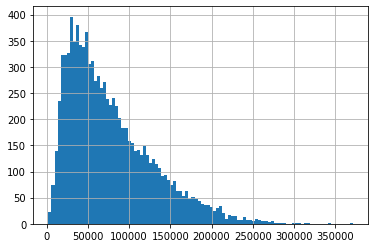

In [ ]:
# calculate minimum box area as benchmark for CNN model
df_train['box_area'] = df_train['width'] * df_train['height']
df_train['box_area'].hist(bins=100)
df_train['box_area'].describe()

In [ ]:
# arbitrary value for minimum box area in the CNN model
min_box_area = 10000

The following code prepares the training data in a useful format for the unet model.

In [ ]:
# shuffle and create patient ID list, then split into train and validation sets
validation_frac = 0.10

df_train = df_train.sample(frac=1, random_state=42) # .sample(frac=1) does the shuffling
pIds = [pId for pId in df_train['patientId'].unique()]

pIds_valid = pIds[ : int(round(validation_frac*len(pIds)))]
pIds_train = pIds[int(round(validation_frac*len(pIds))) : ]

print('{} patient IDs shuffled and {}% of them used in validation set.'.format(len(pIds), validation_frac*100))
print('{} images went into train set and {} images went into validation set.'.format(len(pIds_train), len(pIds_valid)))

# get test set patient IDs
pIds_test = df_test['patientId'].unique()
print('{} patient IDs in test set.'.format(len(pIds_test)))

26684 patient IDs shuffled and 10.0% of them used in validation set.
24016 images went into train set and 2668 images went into validation set.
3000 patient IDs in test set.


In [ ]:
def get_boxes_per_patient(df, pId):
    boxes = df.loc[df['patientId']==pId][['x', 'y', 'width', 'height']].astype('int').values.tolist()
    return boxes

In [ ]:
# create dictionary of {patientId : list of boxes}
pId_boxes_dict = {}
for pId in df_train.loc[(df_train['Target']==1)]['patientId'].unique().tolist():
    pId_boxes_dict[pId] = get_boxes_per_patient(df_train, pId)
print('{} ({:.1f}%) images have target boxes.'.format(len(pId_boxes_dict), 100*(len(pId_boxes_dict)/len(pIds))))

6012 (22.5%) images have target boxes.


In [ ]:
# define a MinMaxScaler function for the images
def imgMinMaxScaler(img, scale_range):
    warnings.filterwarnings("ignore")
    img = img.astype('float64')
    img_std = (img - np.min(img)) / (np.max(img) - np.min(img))
    img_scaled = img_std * float(scale_range[1] - scale_range[0]) + float(scale_range[0])
    # round at closest integer and transform to integer 
    img_scaled = np.rint(img_scaled).astype('uint8')

    return img_scaled

In [ ]:
# define a "warping" image/mask function 
def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
       Code adapted from https://gist.github.com/chsasank/4d8f68caf01f041a6453e67fb30f8f5a
    """
    assert len(image.shape)==2, 'Image must have 2 dimensions.'

    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    
    image_warped = map_coordinates(image, indices, order=1).reshape(shape)
    
    return image_warped

In [ ]:
# define the data generator class
class PneumoniaDataset(torchDataset):

    def __init__(self, root, subset, pIds, predict, boxes, rescale_factor=1, transform=None, rotation_angle=0, warping=False):

        self.root = os.path.expanduser(root)
        self.subset = subset
        self.pIds = pIds
        self.predict = predict
        self.boxes = boxes
        self.rescale_factor = rescale_factor
        self.transform = transform
        self.rotation_angle = rotation_angle
        self.warping = warping

        self.data_path = self.root + 'stage_2_'+self.subset+'_images/'
        
    def __getitem__(self, index):
        pId = self.pIds[index]
        # img = pydicom.dcmread(os.path.join(self.data_path, pId+'.dcm'),force=True).pixel_array
        img = pydicom.read_file(os.path.join(self.data_path, pId+'.dcm'),force=True).pixel_array
        # img.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        # img = img.pixel_array
        original_image_shape = img.shape[0]
        image_shape = original_image_shape / self.rescale_factor
        image_shape = int(image_shape)
        # resize image 
        # IMPORTANT: skimage resize function rescales the output from 0 to 1, and pytorch doesn't like this!
        # One solution would be using torchvision rescale function (but need to differentiate img and target transforms)
        # Here I use skimage resize and then rescale the output again from 0 to 255
        img = resize(img, (image_shape, image_shape), mode='reflect')
        img = imgMinMaxScaler(img, (0,255))
        if self.warping:
            img = elastic_transform(img, image_shape*2., image_shape*0.1)
        img = np.expand_dims(img, -1)
        if self.rotation_angle>0:
            angle = self.rotation_angle * (2 * np.random.random_sample() - 1) # generate random angle 
            img = tv.transforms.functional.to_pil_image(img)
            img = tv.transforms.functional.rotate(img, angle, resample=PIL.Image.BILINEAR)

        if self.transform is not None:
            img = self.transform(img)
        
        if not self.predict:
            target = np.zeros((image_shape, image_shape))
            if pId in self.boxes:
                for box in self.boxes[pId]:
                    x, y, w, h = box
                    x = int(round(x/rescale_factor))
                    y = int(round(y/rescale_factor))
                    w = int(round(w/rescale_factor))
                    h = int(round(h/rescale_factor))
                    target[y:y+h, x:x+w] = 255 #
            target = np.expand_dims(target, -1)   
            target = target.astype('uint8')
            if self.rotation_angle>0:
                target = tv.transforms.functional.to_pil_image(target)
                target = tv.transforms.functional.rotate(target, angle, resample=PIL.Image.BILINEAR)

            if self.transform is not None:
                target = self.transform(target)
            return img, target, pId
        else: 
            return img, pId

    def __len__(self):
        return len(self.pIds)

In [ ]:
# manual model parameters
rescale_factor = 4 # resize factor to reduce image size (new_image_shape = original_image_shape / rescale_factor)
batch_size = 16 # I used 25 on GCP

# recalculate minimum box area
min_box_area = int(round(min_box_area / float(rescale_factor**2)))

# TBD add normalization of images into transforms
# define transformation 
transform = tv.transforms.Compose([tv.transforms.ToTensor()])

# create datasets
dataset_train = PneumoniaDataset(root=datapath_orig, subset='train', pIds=pIds_train, predict=False, 
                                 boxes=pId_boxes_dict, rescale_factor=rescale_factor, transform=transform,
                                 rotation_angle=3, warping=True)

dataset_valid = PneumoniaDataset(root=datapath_orig, subset='train', pIds=pIds_valid, predict=False, 
                                 boxes=pId_boxes_dict, rescale_factor=rescale_factor, transform=transform,
                                 rotation_angle=0, warping=False)

dataset_test = PneumoniaDataset(root=datapath_orig, subset='test', pIds=pIds_test, predict=True, 
                                boxes=None, rescale_factor=rescale_factor, transform=transform,
                                rotation_angle=0, warping=False)

# define the dataloaders with the previous dataset
loader_train = DataLoader(dataset=dataset_train,
                           batch_size=batch_size,
                           shuffle=True) 

loader_valid = DataLoader(dataset=dataset_valid,
                           batch_size=batch_size,
                           shuffle=True) 

loader_test = DataLoader(dataset=dataset_test,
                         batch_size=batch_size,
                         shuffle=False) 

In [ ]:
# pIds_train[10006]

In [ ]:
# ds = pydicom.read_file(os.path.join(datapath_orig+'stage_2_train_images/', pIds_train[10006]+'.dcm'))

# print(ds)
# # dcmimg = img.pixel_array
# # print(type(dcmimg))
# # print(dcmimg.dtype)
# # print(dcmimg.shape)
# # plt.figure(figsize=(20,10))
# # plt.imshow(dcmimg)
# # plt.axis('off')

In [ ]:
# for i in range(21656,len(dataset_train)):

#   dataset_train[i]
#   print(i)
# # pIds[10006]

In [ ]:

class conv_block(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True,
                 bn_momentum=0.9, alpha_leaky=0.03):
        super(conv_block, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                              stride=stride, padding=padding, bias=bias)
        self.bn = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=bn_momentum)
        self.activ = nn.LeakyReLU(negative_slope=alpha_leaky)

    def forward(self, x):
        return self.activ(self.bn(self.conv(x)))

class conv_t_block(nn.Module):


    def __init__(self, in_channels, out_channels, output_size=None, kernel_size=3, bias=True,
                 bn_momentum=0.9, alpha_leaky=0.03):
        super(conv_t_block, self).__init__()
        self.conv_t = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=2, padding=1, 
                                         bias=bias)
        self.bn = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=bn_momentum)
        self.activ = nn.LeakyReLU(negative_slope=alpha_leaky)

    def forward(self, x, output_size):
        return self.activ(self.bn(self.conv_t(x, output_size=output_size)))    

In [ ]:
class UNET(nn.Module):

    def __init__(self):
        super(UNET, self).__init__()
        
        self.down_1 = nn.Sequential(conv_block(in_channels=1, out_channels=64), conv_block(in_channels=64, out_channels=64))
        self.down_2 = nn.Sequential(conv_block(in_channels=64, out_channels=128), conv_block(in_channels=128, out_channels=128))
        self.down_3 = nn.Sequential(conv_block(in_channels=128, out_channels=256), conv_block(in_channels=256, out_channels=256))
        self.down_4 = nn.Sequential(conv_block(in_channels=256, out_channels=512), conv_block(in_channels=512, out_channels=512))
        self.down_5 = nn.Sequential(conv_block(in_channels=512, out_channels=512), conv_block(in_channels=512, out_channels=512))

        self.middle = nn.Sequential(conv_block(in_channels=512, out_channels=512), conv_block(in_channels=512, out_channels=512))
        self.middle_t = conv_t_block(in_channels=512, out_channels=256)

        self.up_5 = nn.Sequential(conv_block(in_channels=768, out_channels=512), conv_block(in_channels=512, out_channels=512))
        self.up_5_t = conv_t_block(in_channels=512, out_channels=256)
        self.up_4 = nn.Sequential(conv_block(in_channels=768, out_channels=512), conv_block(in_channels=512, out_channels=512))
        self.up_4_t = conv_t_block(in_channels=512, out_channels=128)
        self.up_3 = nn.Sequential(conv_block(in_channels=384, out_channels=256), conv_block(in_channels=256, out_channels=256))
        self.up_3_t = conv_t_block(in_channels=256, out_channels=64)
        self.up_2 = nn.Sequential(conv_block(in_channels=192, out_channels=128), conv_block(in_channels=128, out_channels=128))
        self.up_2_t = conv_t_block(in_channels=128, out_channels=32)
        self.up_1 = nn.Sequential(conv_block(in_channels=96, out_channels=64), conv_block(in_channels=64, out_channels=1))
        
    def forward(self, x):
        down1 = self.down_1(x) # (1x256x256 -> 64x256x256)
        out = F.max_pool2d(down1, kernel_size=2, stride=2) # (64x256x256 -> 64x128x128)

        down2 = self.down_2(out) # (64x128x128 -> 128x128x128)
        out = F.max_pool2d(down2, kernel_size=2, stride=2) # (128x128x128 -> 128x64x64)

        down3 = self.down_3(out) # (128x64x64 -> 256x64x64)
        out = F.max_pool2d(down3, kernel_size=2, stride=2) # (256x64x64 -> 256x32x32)

        down4 = self.down_4(out) # (256x32x32 -> 512x32x32)
        out = F.max_pool2d(down4, kernel_size=2, stride=2) # (512x32x32 -> 512x16x16)

        down5 = self.down_5(out) # (512x16x16 -> 512x16x16)
        out = F.max_pool2d(down5, kernel_size=2, stride=2) # (512x16x16 -> 512x8x8)

        out = self.middle(out) # (512x8x8 -> 512x8x8)
        out = self.middle_t(out, output_size=down5.size()) # (512x8x8 -> 256x16x16)

        out = torch.cat([down5, out], 1) # (512x16x16-concat-256x16x16 -> 768x16x16)
        out = self.up_5(out) # (768x16x16 -> 512x16x16)
        out = self.up_5_t(out, output_size=down4.size()) # (512x16x16 -> 256x32x32)

        out = torch.cat([down4, out], 1) # (512x32x32-concat-256x32x32 -> 768x32x32)
        out = self.up_4(out) # (768x32x32 -> 512x32x32)
        out = self.up_4_t(out, output_size=down3.size()) # (512x32x32 -> 128x64x64)
        
        out = torch.cat([down3, out], 1) # (256x64x64-concat-128x64x64 -> 384x64x64)
        out = self.up_3(out) # (384x64x64 -> 256x64x64)
        out = self.up_3_t(out, output_size=down2.size()) # (256x64x64 -> 64x128x128)
        
        out = torch.cat([down2, out], 1) # (128x128x128-concat-64x128x128 -> 192x128x128)
        out = self.up_2(out) # (192x128x128 -> 128x128x128)
        out = self.up_2_t(out, output_size=down1.size()) # (128x128x128 -> 32x256x256)
        
        out = torch.cat([down1, out], 1) # (64x256x256-concat-32x256x256 -> 96x256x256)
        out = self.up_1(out) # (96x256x256 -> 1x256x256)
        
        return out    

In [ ]:
from efficientnet_pytorch import EfficientNet
# model_name = 'efficientnet-b1'
# image_size = EfficientNet.get_image_size(model_name)
# print('Image size: ', image_size)

# # Load model
# model = EfficientNet.from_pretrained(model_name,in_channels=1)
# model.eval()
# print('Model image size: ', model._global_params.image_size)


class model1(nn.Module):
    '''
    Custom ResNet module
    '''

    def __init__(self):
        super(model1, self).__init__()
        self.base = EfficientNet.from_name('efficientnet-b0',in_channels=1)#8x8
        # self.layer1 = nn.Sequential(nn.BatchNorm2d(1280, eps=1e-05, momentum=0.9),nn.Conv2d(in_channels=1280, out_channels=1, kernel_size=1),nn.LeakyReLU(negative_slope=0.03))
        # self.layer2 = nn.UpsamplingNearest2d(scale_factor=32)
        self.up_layer1 = nn.Sequential(nn.ConvTranspose2d(in_channels=1280, out_channels=320, kernel_size=3, stride=2, padding=1, output_padding=1), 
                               nn.BatchNorm2d(320, eps=1e-05, momentum=0.9), nn.LeakyReLU(negative_slope=0.03))
        self.up_layer2 = nn.Sequential(nn.ConvTranspose2d(in_channels=320, out_channels=112, kernel_size=3, stride=2, padding=1, output_padding=1), 
                               nn.BatchNorm2d(112, eps=1e-05, momentum=0.9), nn.LeakyReLU(negative_slope=0.03))
        self.up_layer3 = nn.Sequential(nn.ConvTranspose2d(in_channels=112, out_channels=80, kernel_size=3, stride=2, padding=1, output_padding=1), 
                               nn.BatchNorm2d(80, eps=1e-05, momentum=0.9), nn.LeakyReLU(negative_slope=0.03))
        self.up_layer4 = nn.Sequential(nn.ConvTranspose2d(in_channels=80, out_channels=40, kernel_size=3, stride=2, padding=1, output_padding=1), 
                               nn.BatchNorm2d(40, eps=1e-05, momentum=0.9), nn.LeakyReLU(negative_slope=0.03))
        self.up_layer5 = nn.Sequential(nn.ConvTranspose2d(in_channels=40, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1), 
                               nn.BatchNorm2d(16, eps=1e-05, momentum=0.9), nn.LeakyReLU(negative_slope=0.03))
        self.out_layer = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1)
    def forward(self, x):
        out = self.base.extract_features(x)
        # out = self.layer1(out)
        # out = self.layer2(out)
        out = self.up_layer1(out)
        out = self.up_layer2(out)
        out = self.up_layer3(out)
        out = self.up_layer4(out)
        out = self.up_layer5(out)
        out = self.out_layer(out)
        
        return out

In [ ]:
from torchsummary import summary

summary(model1().cuda(),input_size=(1,256,256))

In [ ]:
from torchsummary import summary

summary(UNET().cuda(),input_size=(1,256,256))

In [ ]:
# class model2(nn.Module):
#     '''
#     Custom ResNet module
#     '''

#     def __init__(self):
#         super(model1, self).__init__()
#         self.base = EfficientNet.from_name('efficientnet-b0',in_channels=1)
#         self.layer1 = nn.Sequential(nn.BatchNorm2d(1280, eps=1e-05, momentum=0.9),nn.Conv2d(in_channels=1280, out_channels=1, kernel_size=1),nn.LeakyReLU(negative_slope=0.03))
#         self.layer2 = nn.UpsamplingNearest2d(scale_factor=32)
#     def forward(self, x):
#         out = self.base.extract_features(x)
#         out = self.layer1(out)
#         out = self.layer2(out)
        
#         return out

In [ ]:

class BCEWithLogitsLoss2d(nn.Module):

    def __init__(self, weight=None, size_average=True):
        super(BCEWithLogitsLoss2d, self).__init__()
        self.loss = nn.BCEWithLogitsLoss(weight, size_average)

    def forward(self, scores, targets):
        scores_flat = scores.view(-1)
        targets_flat = targets.view(-1)
        return self.loss(scores_flat, targets_flat)

In [ ]:

def box_mask(box, shape=1024):

    x, y, w, h = box
    mask = np.zeros((shape, shape), dtype=bool)
    mask[y:y+h, x:x+w] = True 
    return mask

def mask_boxes(msk, threshold=0.20, connectivity=None):

    msk = msk[0]
    pos = np.zeros(msk.shape)
    pos[msk>threshold] = 1.
    lbl = skimage.measure.label(pos, connectivity=connectivity)
    predicted_boxes = []
    confidences = []
    for region in skimage.measure.regionprops(lbl):
        y1, x1, y2, x2 = region.bbox
        h = y2 - y1
        w = x2 - x1
        c = np.nanmean(msk[y1:y2, x1:x2])
        if w*h > min_box_area: 
            predicted_boxes.append([x1, y1, w, h])
            confidences.append(c)
    
    return predicted_boxes, confidences

def prediction_string(predicted_boxes, confidences):

    prediction_string = ''
    for c, box in zip(confidences, predicted_boxes):
        prediction_string += ' ' + str(c) + ' ' + ' '.join([str(b) for b in box])
    return prediction_string[1:]   

def IoU(pr, gt):
    IoU = (pr & gt).sum() / ((pr | gt).sum() + 1.e-9)
    return IoU

def precision(tp, fp, fn):
    return float(tp) / (tp + fp + fn + 1.e-9)
def average_precision_image(predicted_boxes, confidences, target_boxes, shape=1024):

    if predicted_boxes == [] and target_boxes == []:
        return np.nan
    else:
        if len(predicted_boxes)>0 and target_boxes == []:
            return 0.0
        elif len(target_boxes)>0 and predicted_boxes == []:
            return 0.0
        else:
            # define list of thresholds for IoU [0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75]
            thresholds = np.arange(0.4, 0.8, 0.05) 
            # sort boxes according to their confidence (from largest to smallest)
            predicted_boxes_sorted = list(reversed([b for _, b in sorted(zip(confidences, predicted_boxes),key=lambda pair: pair[0])]))            
            average_precision = 0.0
            for t in thresholds: 
                tp = 0 
                fp = len(predicted_boxes)  
                for box_p in predicted_boxes_sorted: 
                    box_p_msk = box_mask(box_p, shape) 
                    for box_t in target_boxes: 
                        box_t_msk = box_mask(box_t, shape) 
                        iou = IoU(box_p_msk, box_t_msk) 
                        if iou>t:
                            tp += 1 
                            fp -= 1 
                            break 
                fn = len(target_boxes) 
                for box_t in target_boxes: 
                    box_t_msk = box_mask(box_t, shape) 
                    for box_p in predicted_boxes_sorted: 
                        box_p_msk = box_mask(box_p, shape) 
                        iou = IoU(box_p_msk, box_t_msk) 
                        if iou>t:
                            fn -= 1
                            break 
               
                average_precision += precision(tp, fp, fn) / float(len(thresholds))
            return average_precision

def average_precision_batch(output_batch, pIds, pId_boxes_dict, rescale_factor, shape=1024, return_array=False):
    
    batch_precisions = []
    for msk, pId in zip(output_batch, pIds): 
        target_boxes = pId_boxes_dict[pId] if pId in pId_boxes_dict else []

        if len(target_boxes)>0:
            target_boxes = [[int(round(c/float(rescale_factor))) for c in box_t] for box_t in target_boxes]

        predicted_boxes, confidences = mask_boxes(msk) 
        batch_precisions.append(average_precision_image(predicted_boxes, confidences, target_boxes, shape=shape))
    if return_array:
        return np.asarray(batch_precisions)
    else:
        return np.nanmean(np.asarray(batch_precisions)) 
  


In [ ]:
class RunningAverage():

    def __init__(self):
        self.steps = 0
        self.total = 0
    
    def update(self, val):
        self.total += val
        self.steps += 1
    
    def __call__(self):
        return self.total/float(self.steps)

In [ ]:
def save_checkpoint(state, is_best, metric):
    filename = 'last.pth.tar'
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, metric+'.best.pth.tar')

In [ ]:
def mean_iou(y_true, y_pred, device):
    y_pred = torch.round(y_pred)
    intersect = (y_true * y_pred).sum(axis=[1, 2, 3])
    union = y_true.sum(axis=[1, 2, 3]) + y_pred.sum(axis=[1, 2, 3])
    smooth = torch.ones(intersect.shape).cuda()
    return ((intersect + smooth) / (union - intersect + smooth)).mean()

In [ ]:
# for i, (input_batch, labels_batch, pIds_batch) in enumerate(loader_train):
#   print(i)

In [ ]:

def train(model, dataloader, optimizer, loss_fn, num_steps, pId_boxes_dict, rescale_factor, shape, save_summary_steps=10):

    model.train()

    summary = []
    loss_avg = RunningAverage()

    loss_avg_t_hist_ep, loss_t_hist_ep, prec_t_hist_ep = [], [], []


    start = time.time()        
    
    for i, (input_batch, labels_batch, pIds_batch) in enumerate(dataloader):
        # if i > num_steps:
        #     break

        input_batch = Variable(input_batch).cuda() if gpu_available else Variable(input_batch).float()
        labels_batch = Variable(labels_batch).cuda() if gpu_available else Variable(labels_batch).float()

        optimizer.zero_grad()
        output_batch = model(input_batch)

        loss = loss_fn(output_batch, labels_batch)

        loss.backward()
        optimizer.step()

        loss_avg.update(loss.item())
        loss_t_hist_ep.append(loss.item())
        loss_avg_t_hist_ep.append(loss_avg())

        if i % save_summary_steps == 0:

            output_batch = output_batch.data.cpu().numpy()
            prec_batch = average_precision_batch(output_batch, pIds_batch, pId_boxes_dict, rescale_factor, shape)
            prec_t_hist_ep.append(prec_batch)
            summary_batch_string = "batch loss = {:05.7f} ;  ".format(loss.item())
            summary_batch_string += "average loss = {:05.7f} ;  ".format(loss_avg())
            summary_batch_string += "batch precision = {:05.7f} ;  ".format(prec_batch)
            
            print('--- Train batch {} / {}: '.format(i, num_steps) + summary_batch_string)
            delta_time = time.time() - start
            print('    {} batches processed in {:.2f} seconds'.format(save_summary_steps, delta_time))
            start = time.time()

    metrics_string = "average loss = {:05.7f} ;  ".format(loss_avg())
    print("- Train epoch metrics summary: " + metrics_string)
    
    return loss_avg_t_hist_ep, loss_t_hist_ep, prec_t_hist_ep

In [ ]:
def evaluate(model, dataloader, loss_fn, num_steps, pId_boxes_dict, rescale_factor, shape):

    model.eval()
    losses = []
    precisions = []

    start = time.time()
    for i, (input_batch, labels_batch, pIds_batch) in enumerate(dataloader):
        if i > num_steps:
            break
        input_batch = Variable(input_batch).cuda() if gpu_available else Variable(input_batch).float()
        labels_batch = Variable(labels_batch).cuda() if gpu_available else Variable(labels_batch).float()

        output_batch = model(input_batch)
        
        loss = loss_fn(output_batch, labels_batch)
        losses.append(loss.item())

        output_batch = output_batch.data.cpu()
        prec_batch = average_precision_batch(output_batch, pIds_batch, pId_boxes_dict, rescale_factor, shape, return_array=True)
        # iou = mean_iou(out, y, device)
        for p in prec_batch:
            precisions.append(p)
        print('--- Validation batch {} / {}: '.format(i, num_steps))

    metrics_mean = {'loss' : np.nanmean(losses),
                    'precision' : np.nanmean(np.asarray(precisions)),
                    }
    metrics_string = "average loss = {:05.7f} ;  ".format(metrics_mean['loss'])
    # metrics_string += "average precision = {:05.7f} ;  ".format(metrics_mean['precision'])
    print("- Eval metrics : " + metrics_string)
    delta_time = time.time() - start
    print('  Evaluation run in {:.2f} seconds.'.format(delta_time))
    
    return metrics_mean

In [ ]:
def train_and_evaluate(model, train_dataloader, val_dataloader, lr_init, loss_fn, num_epochs, 
                       num_steps_train, num_steps_eval, pId_boxes_dict, rescale_factor, shape, restore_file=None):

    if restore_file is not None:
        checkpoint = torch.load(restore_file)
        model.load_state_dict(checkpoint['state_dict'])
            
    best_val_loss = 1e+15
    best_val_prec = 0.0
    best_loss_model = None
    best_prec_model = None

    loss_t_history = []
    loss_v_history = []
    loss_avg_t_history = []
    prec_t_history = []
    prec_v_history = []

    for epoch in range(num_epochs):
        start = time.time()
        lr = lr_init * 0.5**float(epoch) # reduce the learning rate at each epoch
        # lr = 0.001
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        print("Epoch {}/{}. Learning rate = {:05.3f}.".format(epoch + 1, num_epochs, lr))
        loss_avg_t_hist_ep, loss_t_hist_ep, prec_t_hist_ep = train(model, train_dataloader, optimizer, loss_fn, 
                                                                   num_steps_train, pId_boxes_dict, rescale_factor, shape)
        loss_avg_t_history += loss_avg_t_hist_ep
        loss_t_history += loss_t_hist_ep
        prec_t_history += prec_t_hist_ep
        
        val_metrics = evaluate(model, val_dataloader, loss_fn, num_steps_eval, pId_boxes_dict, rescale_factor, shape)

        val_loss = val_metrics['loss']
        val_prec = val_metrics['precision']
        
        loss_v_history += len(loss_t_hist_ep) * [val_loss]
        prec_v_history += len(prec_t_hist_ep) * [val_prec]

        is_best_loss = val_loss<=best_val_loss
        is_best_prec = val_prec>=best_val_prec
        
        if is_best_loss:
            print("- Found new best loss: {:.4f}".format(val_loss))
            best_val_loss = val_loss
            best_loss_model = model
        if is_best_prec:
            print("- Found new best precision: {:.4f}".format(val_prec))
            best_val_prec = val_prec
            best_prec_model = model
            
        save_checkpoint({'epoch': epoch + 1,
                         'state_dict': model.state_dict(),
                         'optim_dict' : optimizer.state_dict()},
                         is_best=is_best_loss,
                         metric='loss')
        save_checkpoint({'epoch': epoch + 1,
                         'state_dict': model.state_dict(),
                         'optim_dict' : optimizer.state_dict()},
                         is_best=is_best_prec,
                         metric='prec')
        
        delta_time = time.time() - start
        print('Epoch run in {:.2f} minutes'.format(delta_time/60.))

    histories = {'loss avg train' : loss_avg_t_history,
                 'loss train' : loss_t_history,
                 'precision train' : prec_t_history,
                 'loss validation' : loss_v_history, 
                 'precision validation' : prec_v_history}
    best_models = {'best loss model' : best_loss_model,
                   'best precision model' : best_prec_model}
    
    return histories, best_models

In [ ]:
def predict(model, dataloader): 

    model.eval()
    
    predictions = {}

    for i, (test_batch, pIds) in enumerate(dataloader):
        print('Predicting batch {} / {}.'.format(i+1, len(dataloader)))
        test_batch = Variable(test_batch).cuda() if gpu_available else Variable(test_batch).float()
            
        output_batch = model(test_batch)
        sig = nn.Sigmoid().cuda()
        output_batch = sig(output_batch)
        output_batch = output_batch.data.cpu().numpy()
        for pId, output in zip(pIds, output_batch):
            predictions[pId] = output
        
    return predictions

In [ ]:

debug = False

model = model1().cuda() if gpu_available else model1()
loss_fn = BCEWithLogitsLoss2d().cuda() if gpu_available else BCEWithLogitsLoss2d()
lr_init = 0.001

num_epochs = 2
num_steps_train = len(loader_train)
num_steps_eval = len(loader_valid)

shape = int(round(original_image_shape / rescale_factor))

print("Starting training for {} epochs".format(num_epochs))
histories, best_models = train_and_evaluate(model, loader_train, loader_valid, lr_init, loss_fn, 
                                            num_epochs, num_steps_train, num_steps_eval, pId_boxes_dict, rescale_factor, shape)

In [ ]:
debug = False

model = UNET().cuda() if gpu_available else model1()
loss_fn = BCEWithLogitsLoss2d().cuda() if gpu_available else BCEWithLogitsLoss2d()
lr_init = 0.5
num_epochs = 2
num_steps_train = len(loader_train)
num_steps_eval = len(loader_valid)
shape = int(round(original_image_shape / rescale_factor))

print("Starting training for {} epochs".format(num_epochs))
histories, best_models = train_and_evaluate(model, loader_train, loader_valid, lr_init, loss_fn, 
                                            num_epochs, num_steps_train, num_steps_eval, pId_boxes_dict, rescale_factor, shape)

In [ ]:

plt.plot(range(len(histories['loss train'])), histories['loss train'], color='k', label='loss train')
plt.plot(range(len(histories['loss avg train'])), histories['loss avg train'], color='g', ls='dashed', label='loss avg train')
plt.plot(range(len(histories['loss validation'])), histories['loss validation'], color='r', label='loss validation')
plt.legend()

In [ ]:
# plt.plot(range(len(histories['precision train'])), histories['precision train'], color='k', label='precision train')
# plt.plot(range(len(histories['precision validation'])), histories['precision validation'], color='r', label='precision validation')
# plt.legend()

In [ ]:
best_model = best_models['best precision model']

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/Colab_Notebooks/project/data/save/loss.best.pth.tar')
best_model = model1().cuda() if gpu_available else model1()
loss_fn = BCEWithLogitsLoss2d().cuda() if gpu_available else BCEWithLogitsLoss2d()
lr_init = 0.002
best_model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:

dataset_valid = PneumoniaDataset(root=datapath_orig, subset='train', pIds=pIds_valid, predict=True, 
                                 boxes=None, rescale_factor=rescale_factor, transform=transform)
loader_valid = DataLoader(dataset=dataset_valid,
                          batch_size=batch_size,
                          shuffle=False) 

predictions_valid = predict(best_model, loader_valid)
print('Predicted {} validation images.'.format(len(predictions_valid)))

Predicting batch 1 / 167.
Predicting batch 2 / 167.
Predicting batch 3 / 167.
Predicting batch 4 / 167.
Predicting batch 5 / 167.
Predicting batch 6 / 167.
Predicting batch 7 / 167.
Predicting batch 8 / 167.
Predicting batch 9 / 167.
Predicting batch 10 / 167.
Predicting batch 11 / 167.
Predicting batch 12 / 167.
Predicting batch 13 / 167.
Predicting batch 14 / 167.
Predicting batch 15 / 167.
Predicting batch 16 / 167.
Predicting batch 17 / 167.
Predicting batch 18 / 167.
Predicting batch 19 / 167.
Predicting batch 20 / 167.
Predicting batch 21 / 167.
Predicting batch 22 / 167.
Predicting batch 23 / 167.
Predicting batch 24 / 167.
Predicting batch 25 / 167.
Predicting batch 26 / 167.
Predicting batch 27 / 167.
Predicting batch 28 / 167.
Predicting batch 29 / 167.
Predicting batch 30 / 167.
Predicting batch 31 / 167.
Predicting batch 32 / 167.
Predicting batch 33 / 167.
Predicting batch 34 / 167.
Predicting batch 35 / 167.
Predicting batch 36 / 167.
Predicting batch 37 / 167.
Predicting

In [ ]:
def rescale_box_coordinates(box, rescale_factor):
    x, y, w, h = box
    x = int(round(x/rescale_factor))
    y = int(round(y/rescale_factor))
    w = int(round(w/rescale_factor))
    h = int(round(h/rescale_factor))
    return [x, y, w, h]    

In [ ]:
def draw_boxes(predicted_boxes, confidences, target_boxes, ax, angle=0):
    if len(predicted_boxes)>0 and len(target_boxes)>0:
      for box_p, box_t, c in zip(predicted_boxes,target_boxes, confidences):
            xp, yp, wp, hp = box_p 
            patch_p = Rectangle((xp,yp), wp, hp, color='red', ls='dashed',
                              angle=angle, fill=False, lw=4, joinstyle='round', alpha=0.6)

            ax.add_patch(patch_p)
            ax.text(xp+wp/2., y-5, 'Confidence：{:.2}'.format(c), color='red', size=20, va='center', ha='center')

            xt, yt, wt, ht = box_t
            patch_t = Rectangle((xt,yt), wt, ht, color='red',  
                              angle=angle, fill=False, lw=4, joinstyle='round', alpha=0.6)
            ax.add_patch(patch_t)
            box_p_msk = box_mask(box_p, shape=shape)
            box_t_msk = box_mask(box_t, shape=shape)
            iou = IoU(box_p_msk, box_t_msk)
            
            ax.text(x+w/2., y-5, 'Confidence：{:.2}'.format(c), color='red', size=20, va='center', ha='center')
        return ax
    if len(predicted_boxes)>0:
        for box, c in zip(predicted_boxes, confidences):

            x, y, w, h = box 
            patch = Rectangle((x,y), w, h, color='red', ls='dashed',
                              angle=angle, fill=False, lw=4, joinstyle='round', alpha=0.6)
            ax.add_patch(patch)

            ax.text(x+w/2., y-5, 'Confidence：{:.2}'.format(c), color='red', size=20, va='center', ha='center')
            ax.text(x+w/2., y-5, 'Confidence：{:.2}'.format(c), color='red', size=20, va='center', ha='center')
    if len(target_boxes)>0:
        for box in target_boxes:
            x, y, w, h = box
            patch = Rectangle((x,y), w, h, color='red',  
                              angle=angle, fill=False, lw=4, joinstyle='round', alpha=0.6)
            ax.add_patch(patch)
    
    return ax

In [ ]:
best_threshold = None
best_avg_precision_valid = 0.0
thresholds = np.arange(0.15, 0.25, 0.01)
avg_precision_valids = []
for threshold in thresholds:
    precision_valid = []
    for i in range(len(dataset_valid)):
        img, pId = dataset_valid[i]
        target_boxes = [rescale_box_coordinates(box, rescale_factor) for box in pId_boxes_dict[pId]] if pId in pId_boxes_dict else []
        prediction = predictions_valid[pId]
        predicted_boxes, confidences = mask_boxes(prediction, threshold=threshold, connectivity=None)
        avg_precision_img = average_precision_image(predicted_boxes, confidences, target_boxes, shape=img[0].shape[0])
        precision_valid.append(avg_precision_img)
    avg_precision_valid = np.nanmean(precision_valid)
    avg_precision_valids.append(avg_precision_valid)
    print('Threshold: {}, average precision validation: {:03.5f}'.format(threshold, avg_precision_valid))
    if avg_precision_valid>best_avg_precision_valid:
        print('Found new best average precision validation!')
        best_avg_precision_valid = avg_precision_valid
        best_threshold = threshold
plt.plot(thresholds, avg_precision_valids)

In [ ]:
for i in range(len(dataset_valid)):
    img, pId = dataset_valid[i]
    target_boxes = [rescale_box_coordinates(box, rescale_factor) for box in pId_boxes_dict[pId]] if pId in pId_boxes_dict else []
    prediction = predictions_valid[pId]
    predicted_boxes, confidences = mask_boxes(prediction, threshold=best_threshold, connectivity=None)
    avg_precision_img = average_precision_image(predicted_boxes, confidences, target_boxes, shape=img[0].shape[0])
    if i%100==0: # print every 100
        plt.imshow(img[0], cmap=mpl.cm.gist_gray) # [0] is the channel index (here there's just one channel)
        plt.imshow(prediction[0], cmap=mpl.cm.jet, alpha=0.5)
        draw_boxes(predicted_boxes, confidences, target_boxes, plt.gca())
        print('Prediction mask scale:', prediction[0].min(), '-', prediction[0].max())
        print('Prediction string:', prediction_string(predicted_boxes, confidences))
        print('Ground truth boxes:', target_boxes)
        print('Average precision image: {:05.5f}'.format(avg_precision_img))
        plt.show()


In [ ]:
# def mean_iou(y_true, y_pred):
#     '''
#     Mean-Intersection-Over-Union
#     '''
#     y_pred = torch.round(y_pred)
#     intersect = (y_true * y_pred).sum(axis=[1, 2, 3])
#     union = y_true.sum(axis=[1, 2, 3]) + y_pred.sum(axis=[1, 2, 3])
#     smooth = torch.ones(intersect.shape).cuda()
#     return ((intersect + smooth) / (union - intersect + smooth)).mean()


# for i,(input_batch, labels_batch, pIds_batch) in enumerate(loader_train):
#   input_batch = Variable(input_batch).cuda() if gpu_available else Variable(input_batch).float()
#   labels_batch = Variable(labels_batch).cuda() if gpu_available else Variable(labels_batch).float()
            
#   # compute output

#   output_batch = model(input_batch)
#   iou = mean_iou(labels_batch,output_batch)
#   print(iou)